In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import time
import os
import h5py
%matplotlib inline 
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
from visualization.visualize_funcs import *
sys.path.append('src_cython')
from zwatershed import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'

# Test Evaluation

In [2]:
start = time.clock()
threshes = [100,200,300,400,500,600,700,800,900,1000,2000] # for i in range(1,6)]+[i*20000 for i in range(2,16)] # 100...1,000...100,000
iters = [10000]
strs = ["2"]
hdf5_gt_file = path_to_data + 'groundtruth_seg_thick.h5' #/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
hdf5_pred_file = path_to_data + 'tstvol-1_2.h5' # /tier2/turaga/singhc/train/output_200000/tstvol-1_2.h5'
out = path_to_data + 'out/'# '/groups/turaga/home/singhc/evaluation/out/'
save_threshes = threshes
rand = 0
p_small = 150
p1 = 200
p2 = 180
p3 = 190

hdf5_gt = h5py.File(hdf5_gt_file, 'r')
hdf5_aff = h5py.File(hdf5_pred_file, 'r')
gt = np.asarray(hdf5_gt[hdf5_gt.keys()[0]],dtype='uint32')
aff = np.asarray(hdf5_aff[hdf5_aff.keys()[0]],dtype='float32')
aff = aff[:,p1:(-1*p1),p2:(-1*p2),p3:(-1*p3)]

dims = np.array(aff.shape,dtype='uint32')
print 'dims:',aff.shape


# trim gt data - only works for perfect cubes
gt = trim_arbitrary_aff(gt,aff)
print gt.shape,aff.shape


segs,rand = zwatershed_and_metrics(gt, aff, threshes, save_threshes)
# segs = zwatershed(aff, threshes)
# rand = zwatershed_and_metrics_h5(gt, aff, threshes, save_threshes, out)
# zwatershed_h5(aff, threshes, out)

print rand
print sum(segs[0][0][0:100][0])
print "time: ",time.clock()-start

dims: (3, 32, 72, 52)
(32, 72, 52) (3, 32, 72, 52)
{'V_Rand_merge': [0.9999355143435628, 0.9999348679262107, 0.9999324796025494, 0.9999294153247565, 0.9999287904487932, 0.9999291959561357, 0.9999282092230092, 0.9999281933206109, 0.9999281216387342, 0.9999303791269568, 0.9999019559608536], 'V_Rand_split': [0.8138567729500639, 0.816576559467863, 0.8221099004359028, 0.827410271578654, 0.8277575546442787, 0.8335729080641194, 0.8339836417293655, 0.8339847754430703, 0.8339884658513363, 0.8614066324881156, 0.9409427718642841], 'V_Rand': 0.9695268297826364}
3582
time:  1.191198


# View Segmentations 

In [3]:
## Open training data and labels
data_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/data/'# 'nobackup/turaga/data/FlyEM/fibsem_medulla_7col/tstvol-520-1/'
os.chdir('/.')
f = h5py.File(data_folder + 'im_uint8.h5', 'r')
im = f[f.keys()[0]] # was 'main'
g = h5py.File(data_folder + 'groundtruth_aff.h5', 'r')
label_set = np.asarray(g[g.keys()[0]],dtype='float32') #3,z,y,x - was 'main'
label_set = np.transpose(label_set,(1,2,3,0))

(32, 72, 52) (32, 72, 52, 3) (32, 72, 52)


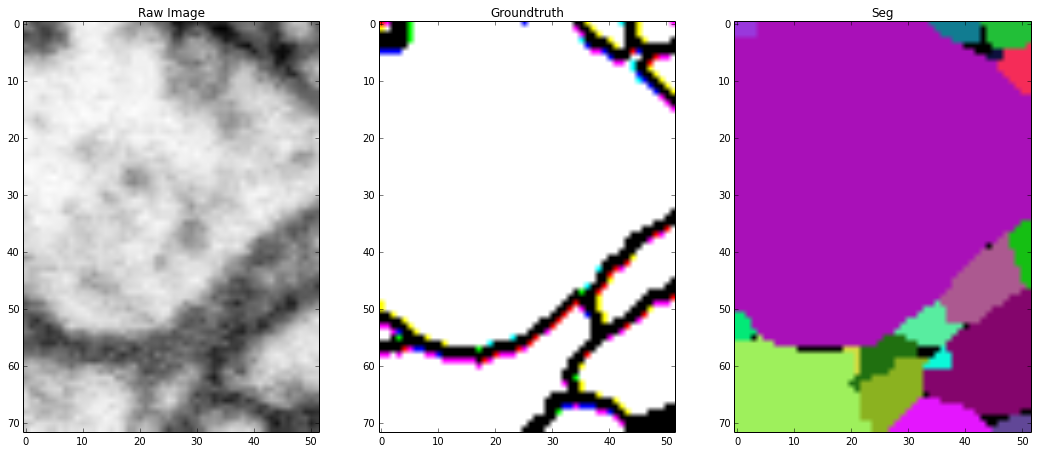

In [4]:
# view segs
seg = segs[0]
# im,label_set=trim(im,label_set,seg) 
# seg = seg.transpose((2, 1, 0)).reshape(shape).transpose((2, 1, 0))
im,label_set=trim_arbitrary(im,label_set,seg) 
print im.shape,label_set.shape,seg.shape
# display_seg(im, label_set, seg, im_size=label_set.shape[0], im2_size=seg.shape[0])
display_arbitrary_seg(im, label_set, seg)

# Test Evaluate

('dims:', (3, 132, 132, 132))
data dimension do not match - clipping GT borders.
('New GT data shape :', (132, 132, 132))
edge_affs:  [1 1 1 ..., 1 1 1]
percent below thresh 0.631578932113
num segs seg_cc 9106
num segs gt 1916
rgn graph 2 len 184
num segs seg_cc 9026
num segs gt 1916


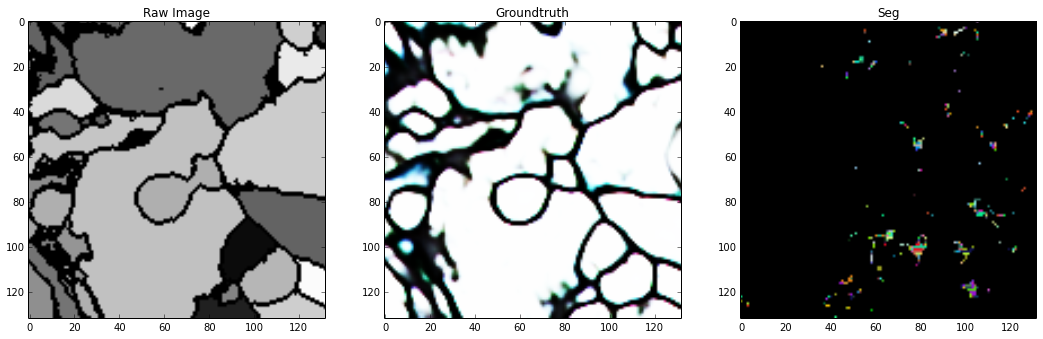

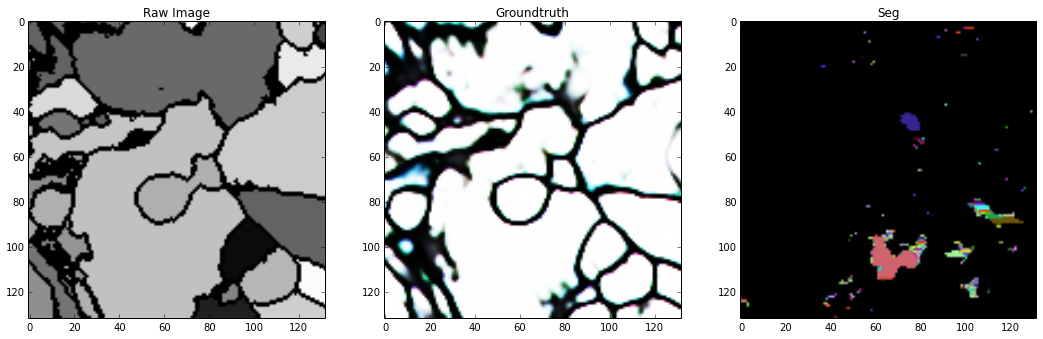

In [1]:
import numpy as np
import h5py
import datetime

np.set_printoptions(precision=4)
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
import matplotlib
%matplotlib inline 


sys.path.append('arb_nhoods')
sys.path.append('../')
import twatershed as tw
from visualization.visualize_funcs import *

path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'

threshes = [500, 1000, 2000]  # for i in range(1,6)]+[i*20000 for i in range(2,16)] # 100...1,000...100,000
iters = [10000]
strs = ["2"]
hdf5_gt_file = path_to_data + 'groundtruth_seg_thick.h5'  # /groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
hdf5_pred_file = path_to_data + 'tstvol-1_2.h5'  # /tier2/turaga/singhc/train/output_200000/tstvol-1_2.h5'
out = path_to_data + 'out/'  # '/groups/turaga/home/singhc/evaluation/out/'
save_threshes = threshes
rand = 0
p_small = 150

hdf5_gt = h5py.File(hdf5_gt_file, 'r')
hdf5_aff = h5py.File(hdf5_pred_file, 'r')
gt = np.asarray(hdf5_gt[hdf5_gt.keys()[0]], dtype='int32')
aff = np.asarray(hdf5_aff[hdf5_aff.keys()[0]], dtype='float32')
aff = aff[:, p_small:(-1 * p_small), p_small:(-1 * p_small), p_small:(-1 * p_small)]

dims = np.array(aff.shape, dtype='uint32')
print('dims:', aff.shape)

# trim gt data - only works for perfect cubes
gt_data_dimension = gt.shape[0]
data_dimension = aff.shape[1]
if gt_data_dimension != data_dimension:
    print("data dimension do not match - clipping GT borders.")
    padding = (gt_data_dimension - data_dimension) / 2
    gt = gt[padding:(-1 * padding), padding:(-1 * padding), padding:(-1 * padding)]
    print("New GT data shape :", gt.shape)

nhood = tw.mknhood3d(1)
node1, node2, edge_affs = tw.affgraph_to_edgelist(aff, nhood)
node1 = np.array(node1, dtype='int32')
node2 = np.array(node2, dtype='int32')
THRESH = .9999  # higher is more connected
# print node1[0:40]
# print node2[0:40]
edge_affs_thresh = np.array(edge_affs <= THRESH, dtype='int32')
print "edge_affs: ", edge_affs_thresh
print "percent below thresh", sum(edge_affs <= THRESH) / float(len(edge_affs))
seg_cc, _ = tw.connected_components(int(np.size(gt)), node1, node2, edge_affs_thresh)
print "num segs seg_cc", max(seg_cc.flatten())
print "num segs gt", max(gt.flatten())
# seg_cc = gt
seg, seg_sizes = tw.marker_watershed(seg_cc.flatten(), node1, node2, edge_affs)
# print "output_seg_len", len(seg_sizes)
print "num segs seg_cc", max(seg.flatten())
print "num segs gt", max(gt.flatten())
seg = seg.reshape(gt.shape)

aff = aff.transpose(1, 2, 3, 0)
display_arbitrary_seg(gt, aff, seg_cc.reshape(gt.shape))
display_arbitrary_seg(gt, aff, seg)